## Imports

In [1]:

from sklearn.metrics import  confusion_matrix
import spacy
import nltk
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import shap
import re
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.svm import SVR
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
random_seed = 42
from xgboost import XGBClassifier
tqdm.pandas()
import scipy.stats as st


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## data

### read

In [2]:
df_features = pd.read_csv('../data/processed/processed_dataset.csv')
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,...,child_lemma,child_pos,child_tag,child_shape,child_is_alpha,child_is_stop,child_morph,child_ner,child_ner_start_end,parent_ner_start_end
0,sci,1,ter,person,:ARG0,nsubj,tem,ter,VERB,VERB,...,Meyer,PROPN,PROPN,Xxxxx,True,False,Gender=Masc|Number=Sing,PER,"[0, 1]",NaN
1,sci,4,fazer,isso,:ARG1,nao_tem_dep,feito,fazer,VERB,VERB,...,isso,PRON,PRON,Xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
2,sci,4,fazer,universidade,:ARG3,obl,feito,fazer,VERB,VERB,...,universidade,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN
3,sci,12,acontecer,isso,:ARG1,nsubj,acontece,acontecer,VERB,VERB,...,isso,PRON,PRON,xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
4,sci,16,entender,otimista,:ARG0,nsubj,entendem,entender,VERB,VERB,...,otimista,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Plur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,PropBankBr_v1.1_Dep,propbank_3347,ser,Abram_Szajman,ARG1,nao_tem_dep,é,ser,AUX,AUX,...,Abram_Szajman,PROPN,PROPN,Xxxxx_Xxxxx,False,False,Gender=Masc|Number=Sing,LOC,"[0, 1]",NaN
13242,PropBankBr_v1.1_Dep,propbank_3347,ser,presidente,ARG2,ROOT,é,ser,AUX,AUX,...,presidente,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Sing,NaN,NaN,NaN
13243,PropBankBr_v1.1_Dep,propbank_3348,surpreender,que,ARG0,nsubj,surpreendeu,surpreender,VERB,VERB,...,que,PRON,PRON,xxx,True,True,Gender=Masc|Number=Sing|PronType=Rel,NaN,NaN,NaN
13244,PropBankBr_v1.1_Dep,propbank_3348,surpreender,galera,ARG1,obj,surpreendeu,surpreender,VERB,VERB,...,galera,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN


### drop useless columns

In [3]:
# dropa colunas inuteis
df_features = df_features.drop(['parent_shape',
       'parent_is_alpha', 'parent_is_stop', 'parent_morph', 'child_shape',
       'child_is_alpha', 'child_is_stop', 'child_morph', 
       'child_ner_start_end', 'parent_ner_start_end'],axis = 1)

df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner'],
      dtype='object')

### Fill nan values

In [4]:
df_features.isna().sum()

corpus_name         0
id                  0
parent              0
child               0
label               0
dep                 0
parent_text         0
parent_lemma        0
parent_pos          0
parent_tag          0
parent_ner      13148
child_text          0
child_lemma         0
child_pos           0
child_tag           0
child_ner       11989
dtype: int64

In [5]:
df_features.groupby('corpus_name').apply(lambda x: x.isna().sum())

/tmp/ipykernel_3095975/2542205653.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features.groupby('corpus_name').apply(lambda x: x.isna().sum())


,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner
corpus_name,,,,,,,,,,,,,,,,
PropBankBr_v1.1_Dep,0,0,0,0,0,0,0,0,0,0,10113,0,0,0,0,8982
lp,0,0,0,0,0,0,0,0,0,0,1587,0,0,0,0,1572
news,0,0,0,0,0,0,0,0,0,0,983,0,0,0,0,981
opisums,0,0,0,0,0,0,0,0,0,0,373,0,0,0,0,366
sci,0,0,0,0,0,0,0,0,0,0,92,0,0,0,0,88


In [6]:
### all nan to nsa (nao se aplica)
df_features.fillna('nsa', inplace = True)

### transform and create label

In [7]:
df_features.label.value_counts()

label
ARG1         5440
ARG0         3057
:ARG1        1517
ARG2         1413
:ARG0        1033
:ARG2         296
ARG3          151
ARG4          114
:ARG1-of       95
:ARG0-of       63
:ARG3          37
:ARG4          23
:ARG2-of        5
:ARG01-of       1
ARG5            1
Name: count, dtype: int64

In [8]:
# ################################
# # Completo 
# ################################

df_features['label'] = df_features.label.apply(
    lambda x: 
        0 if "arg0" in x.casefold() else
        1 if "arg1" in x.casefold() else
        # 2 if "arg2" in x.casefold() else
        # 3 if "arg3" in x.casefold() else
        # 4 if "arg4" in x.casefold() else
     #   5 if "arg5" in x.casefold() else
        "erro"
        
)

df_features['label'].value_counts()

df_features = df_features[
    (df_features.label != 'erro')]
df_features.label.value_counts()

label
1    7052
0    4154
Name: count, dtype: int64

In [9]:
df_features.groupby(['corpus_name', 'label']).size()

corpus_name          label
PropBankBr_v1.1_Dep  0        3057
                     1        5440
lp                   0         642
                     1         807
news                 0         299
                     1         560
opisums              0         132
                     1         196
sci                  0          24
                     1          49
dtype: int64

In [10]:
df_features.label = df_features.label.astype('int')

In [11]:
df_features['stratify-column'] = df_features.apply(lambda x: str(x.corpus_name) + "_" + str(x.label), axis = 1)
df_features['stratify-column']

0                        sci_0
1                        sci_1
3                        sci_1
4                        sci_0
5                        sci_1
                 ...          
13240    PropBankBr_v1.1_Dep_1
13241    PropBankBr_v1.1_Dep_1
13243    PropBankBr_v1.1_Dep_0
13244    PropBankBr_v1.1_Dep_1
13245    PropBankBr_v1.1_Dep_1
Name: stratify-column, Length: 11206, dtype: object

### features and label

In [12]:
# separa propbank que só vai no treino
propbank_index = df_features[df_features.corpus_name == "PropBankBr_v1.1_Dep"].index.tolist()

In [13]:
X = df_features.drop(['corpus_name', 'id', 'stratify-column', "label"], axis = 1)
y = df_features['label']

In [14]:
display(X.head())
display(y.head())

,parent,child,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner
0,ter,person,nsubj,tem,ter,VERB,VERB,nsa,Meyer,Meyer,PROPN,PROPN,PER
1,fazer,isso,nao_tem_dep,feito,fazer,VERB,VERB,nsa,Isso,isso,PRON,PRON,nsa
3,acontecer,isso,nsubj,acontece,acontecer,VERB,VERB,nsa,isso,isso,PRON,PRON,nsa
4,entender,otimista,nsubj,entendem,entender,VERB,VERB,nsa,otimistas,otimista,NOUN,NOUN,nsa
5,querer,cientista,obj,quer,querer,VERB,VERB,nsa,cientistas,cientista,NOUN,NOUN,nsa


0    0
1    1
3    1
4    0
5    1
Name: label, dtype: int64

### col vectorization

In [15]:
# # Obter embeddings para as palavras em cada coluna
def get_embedding(word):
    
    # da pau quando nao tem a palavra
    try:
        return model[word]
    except Exception as e:
        return [-1000 for n in range(len_emb)] 

In [16]:
# carrega o modelo
len_emb= 300
## glove
#model = KeyedVectors.load_word2vec_format(f'../embeddings/glove_s{len_emb}.txt')
## cbow
model = KeyedVectors.load_word2vec_format(f'../embeddings/cbow_s{len_emb}.txt')

In [17]:
#######################################################
# Antigo: lemma
#######################################################
embeddings_parent = X['parent_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
embeddings_child = X['child_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X.index)

X.drop(['parent', 'parent_lemma', 'child', 'child_lemma'], axis=1, inplace = True)

cat_cols = [col for col in X.columns if "emb" not in col]
X_enc = pd.get_dummies(X[cat_cols])
X_enc

X_enc[[f"emb_{n}_lemma_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
X_enc[[f"emb_{n}_lemma_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X_enc.index)

100%|██████████| 11206/11206 [00:00<00:00, 597510.50it/s]
/tmp/ipykernel_3095975/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_3095975/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_3095975/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This 

In [18]:
print(len(X_enc[X_enc[f"emb_1_lemma_parent"] == -1000]))
print(len(X_enc[X_enc[f"emb_1_lemma_child"] == -1000]))

386
1347


### Train test split

In [19]:
###############################################
# train test split com o propbank só no treino
###############################################

# Separar os índices obrigatórios para treino
X_train_obrigatorio = X_enc.loc[propbank_index]
y_train_obrigatorio = y.loc[propbank_index]

# Índices restantes
X_restante = X_enc.drop(propbank_index)
y_restante = y.drop(propbank_index)

# Dividir o restante em treino e teste
X_train_restante, X_test, y_train_restante, y_test = train_test_split(X_restante, y_restante, test_size=0.2, random_state=42, stratify=df_features.drop(propbank_index)['label'])


# Combinar os dados de treino obrigatório com os dados de treino restante
X_train = pd.concat([X_train_restante, X_train_obrigatorio])
y_train = pd.concat([y_train_restante, y_train_obrigatorio])

In [20]:
# remover features que nao variam no treino
features_std_0 = X_train.columns[X_train.std() == 0].tolist()
X_train.drop(features_std_0,axis = 1, inplace=True)
X_test.drop(features_std_0,axis = 1, inplace=True)

## Classification

### Hyperparameter tunning

In [21]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [22]:
#selector = RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)
selector = SelectPercentile()
sampler = RandomOverSampler(sampling_strategy='minority',random_state=random_seed)
scaler = StandardScaler()

estimator = XGBClassifier(
    device = 'cuda',
 #tree_method = 'hist',
#    sample_weights = sample_weights
    )

pipeline_steps = [
    ('scaling', scaler),
    ('selecting', selector),
    ('sampling', sampler),
    ('estimator',estimator)
    ] 



pipeline = Pipeline(steps = pipeline_steps)


# Preconfigure estimator and parameters
params = {  
            "estimator__n_estimators": st.randint(3, 40),
            "estimator__max_depth": st.randint(3, 40),
            "estimator__learning_rate": st.uniform(0.05, 0.4),
            "estimator__colsample_bytree": st.beta(10, 1),
            "estimator__subsample": st.beta(10, 1),
            "estimator__gamma": st.uniform(0, 10),
            'estimator__objective': ['multi:softmax'],
            'estimator__eval_metric':['aucpr'],
            
            #'estimator__scale_pos_weight': st.randint(0, 2),
            "estimator__min_child_weight": st.expon(0, 50),
            "selecting__percentile": [10,25,40,50,80],
            "estimator__num_class": [5]
            
            
        }

# Random Search Training with 5 folds Cross Validation
rf_random = RandomizedSearchCV(
    pipeline, 
    params, 
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), 
    verbose=4,
    n_iter=20, 
    random_state=42, 
    scoring='f1_macro') 
                              
rf_random.fit(X_train, y_train)  
best_params = rf_random.best_params_
best_score = rf_random.best_score_

print('best_params', best_params)
print('best_score', best_score)

model = rf_random.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.904 total time=  28.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.887 total time=  21.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.893 total time=  22.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.882 total time=  20.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.909 total time=  20.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.905 total time=  20.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.910 total time=  21.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.896 total time=  21.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.894 total time=  22.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.910 total time=  25.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.900 total time=  13.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.889 total time=  13.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.895 total time=  12.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.881 total time=  13.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.901 total time=  13.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.900 total time=  12.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.899 total time=  12.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.894 total time=  12.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.898 total time=  15.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.905 total time=  14.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.877 total time=  14.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.870 total time=  15.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.873 total time=  15.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.870 total time=  15.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.885 total time=  15.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.874 total time=  16.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.879 total time=  16.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.862 total time=  17.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.884 total time=  17.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.877 total time=  17.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.887 total time=   9.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.874 total time=   9.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.887 total time=  10.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.879 total time=   9.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.895 total time=   9.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.897 total time=   9.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.883 total time=  10.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.887 total time=  10.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.890 total time=  10.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.891 total time=  10.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.877 total time=  14.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.871 total time=  16.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.876 total time=  16.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.872 total time=  16.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.881 total time=  16.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.884 total time=  15.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.879 total time=  20.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.869 total time=  17.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.887 total time=  18.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.882 total time=  18.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.859 total time=   9.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.863 total time=   9.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.868 total time=   9.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.856 total time=   8.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.876 total time=   8.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.874 total time=   8.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.871 total time=   8.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.860 total time=   9.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.870 total time=   9.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.869 total time=   9.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.870 total time=  19.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.867 total time=  17.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.883 total time=  17.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.869 total time=  16.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.888 total time=  17.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.881 total time=  17.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.889 total time=  17.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.874 total time=  18.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.883 total time=  18.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.890 total time=  18.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.877 total time=  11.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.881 total time=  10.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.890 total time=  11.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.865 total time=  10.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.889 total time=   9.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.877 total time=  10.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.883 total time=   9.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.886 total time=  10.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.878 total time=  10.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.887 total time=  10.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.889 total time=  15.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.884 total time=  17.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.890 total time=  16.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.870 total time=  19.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.894 total time=  19.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.898 total time=  18.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.893 total time=  20.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.883 total time=  17.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.881 total time=  18.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.900 total time=  17.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.909 total time=  10.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.906 total time=  11.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.907 total time=  11.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.892 total time=  11.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.910 total time=  11.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.907 total time=  12.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.905 total time=  11.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.899 total time=  10.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.892 total time=  10.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.908 total time=  10.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.905 total time=  17.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.902 total time=  19.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.911 total time=  22.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.886 total time=  26.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.909 total time=  26.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.901 total time=  23.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.902 total time=  22.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.898 total time=  25.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.888 total time=  23.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.910 total time=  22.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.892 total time=  11.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.879 total time=  11.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.888 total time=  11.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.879 total time=  20.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.894 total time=  15.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.890 total time=  14.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.899 total time=  12.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.882 total time=  14.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.879 total time=  12.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.899 total time=  12.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.882 total time=  19.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.869 total time=  18.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.877 total time=  16.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.866 total time=  16.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.885 total time=  17.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.878 total time=  16.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.879 total time=  17.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.864 total time=  15.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.874 total time=  16.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.888 total time=  15.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.874 total time=  11.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.873 total time=  12.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.886 total time=  11.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.877 total time=  16.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.892 total time=  12.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.877 total time=  13.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.886 total time=  14.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.873 total time=  16.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.883 total time=  15.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.890 total time=  15.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.883 total time=  12.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.872 total time=  12.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.888 total time=  14.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.863 total time=  13.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.889 total time=  12.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.887 total time=  13.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.887 total time=  14.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.880 total time=  10.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.878 total time=  10.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.895 total time=   9.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.905 total time=  18.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.887 total time=  17.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.898 total time=  16.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.878 total time=  15.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.908 total time=  13.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.905 total time=  13.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.902 total time=  14.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.898 total time=  14.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.896 total time=  13.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.907 total time=  14.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.894 total time=   7.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.882 total time=   7.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.893 total time=   7.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.872 total time=   8.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.891 total time=   7.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.890 total time=   7.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.891 total time=   8.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.887 total time=   7.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.875 total time=   8.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.900 total time=   7.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.898 total time=  13.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.891 total time=  14.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.897 total time=  13.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.885 total time=  14.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.909 total time=  14.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.908 total time=  13.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.905 total time=  13.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.899 total time=  14.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.892 total time=  27.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.905 total time=  17.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.900 total time=  12.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.893 total time=  13.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.894 total time=  12.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.878 total time=  11.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.905 total time=  15.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.904 total time=  14.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.909 total time=  13.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.894 total time=  12.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.894 total time=  12.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.911 total time=  10.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   77   83   88   91  164  185  193  215  216  226  234  238  274
  280  286  296  324  332  336  364  390  461  478  494  510  538  560
  576  577  631  645  654  655  681  733  746  778  784  793  805  822
  825  827  834  850  889  892  904  923  959  977  982  996 1021 1037
 1059 1090 1104 1144 1145 1172 1228 1264 1273 1286 1320 1321 1357 1393
 1399 1400 1404 1405 1414 1418 1440 1441 1482 1496 1538 1595 1612 1640
 1650 1664 1674 1726 1786 1835 1841 1845 1893 1902 1913 1922 1986 2026
 2042 2069 2074 2101 2113 2123 2129 2171 2230 2250 2254 2290 2301 2324
 2326 2337 2355 2362 2396 2399 2440 2463 2497 2499 2570 2574 2584 2600
 2642 2651 2676 2696 2716 2723 2742 2756 2763 2783 2802 2817 2858 2912
 2956 2964 2989 3004 3019 3021 3031 3061 3069 3078 3088 3094 3105 3129
 3151 3162 3178 3183 3213 3252 3305 3321 3327 3410 3423 3491 3506 3523
 3541 

[CV 1/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.882 total time=  26.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  43   45   75   95  123  147  153  163  178  195  200  205  208  219
  232  248  257  278  331  333  354  393  402  407  444  551  580  586
  593  699  713  728  757  786  797  828  830  831  833  902  903  913
  968 1008 1009 1026 1032 1078 1138 1159 1251 1256 1381 1406 1424 1448
 1453 1459 1466 1487 1545 1577 1588 1598 1660 1666 1669 1684 1728 1746
 1758 1766 1800 1830 1834 1837 1869 1939 1952 2017 2019 2020 2030 2065
 2083 2096 2108 2255 2269 2273 2274 2331 2336 2346 2353 2368 2393 2402
 2404 2413 2454 2456 2465 2466 2488 2510 2520 2548 2569 2622 2626 2686
 2697 2769 2771 2790 2836 2867 2875 2876 2889 2963 3032 3039 3057 3058
 3079 3081 3085 3119 3139 3174 3182 3202 3210 3219 3225 3227 3371 3402
 3489 3505 3507 3627 3634 3662 3712 3724 3736 3744 3756 3758 3774 3775
 3787 3793 3797 3802 3819 3850 3863 3871 3899 3902 3910 3920 3924 3935
 3936 

[CV 2/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.875 total time=  17.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   47   59   61   64   79   82   85   92  104  115  124  127  142
  143  145  151  169  190  204  221  228  279  293  313  319  416  468
  500  514  527  529  540  562  579  582  590  606  621  663  700  748
  754  866  886  891  906  909  933  938  948 1004 1025 1036 1058 1128
 1149 1189 1205 1262 1263 1266 1328 1331 1359 1371 1391 1407 1415 1427
 1447 1607 1626 1630 1634 1649 1657 1667 1692 1741 1775 1792 1794 1814
 1816 1861 1867 1918 1927 1936 1951 1990 2010 2104 2109 2142 2185 2213
 2218 2249 2258 2263 2270 2277 2291 2333 2334 2348 2400 2411 2426 2526
 2558 2567 2575 2598 2623 2633 2663 2687 2745 2772 2775 2777 2792 2813
 2895 2913 2942 2946 2948 3023 3050 3072 3080 3161 3204 3209 3231 3292
 3306 3324 3328 3433 3435 3438 3515 3519 3589 3599 3607 3613 3616 3622
 3636 3641 3649 3653 3665 3669 3706 3710 3734 3737 3739 3741 3746 3759
 3771 

[CV 3/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.877 total time=  15.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  52   69   72   76   81   93   99  114  116  129  167  175  183  202
  222  241  253  269  305  358  378  406  414  421  426  435  463  466
  512  585  636  656  795  882  896  950 1003 1024 1044 1049 1150 1151
 1160 1216 1217 1227 1312 1317 1335 1342 1351 1403 1430 1438 1544 1564
 1566 1570 1618 1622 1627 1663 1704 1724 1797 1806 1851 1859 1865 1879
 1928 1934 1940 1965 1996 2038 2061 2091 2114 2121 2156 2164 2169 2176
 2178 2187 2191 2261 2272 2288 2307 2311 2325 2351 2382 2467 2557 2620
 2643 2654 2695 2703 2713 2748 2766 2770 2778 2793 2807 2840 2841 2848
 2877 2944 2955 2972 2979 2980 2983 3028 3043 3048 3107 3136 3157 3186
 3187 3190 3205 3208 3212 3230 3246 3275 3295 3308 3319 3332 3344 3345
 3358 3364 3372 3413 3427 3479 3590 3602 3603 3611 3625 3632 3659 3663
 3675 3676 3680 3692 3697 3709 3715 3716 3726 3727 3750 3784 3789 3794
 3799 

[CV 4/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.870 total time=  14.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   63   68   86   97  107  118  125  126  128  133  134  165
  182  192  240  246  247  251  301  321  369  374  389  418  454  486
  488  518  528  539  554  559  568  597  619  637  674  684  696  714
  720  726  774  801  804  820  840  857  877  879  894  897  917  951
  952  971  991 1061 1074 1177 1222 1336 1343 1349 1362 1401 1410 1442
 1444 1476 1491 1504 1512 1520 1524 1529 1541 1591 1673 1689 1708 1718
 1736 1777 1804 1849 1878 1900 1924 1929 1946 1948 2001 2036 2037 2059
 2060 2161 2199 2219 2268 2296 2359 2387 2430 2444 2484 2490 2529 2581
 2634 2649 2660 2666 2668 2672 2678 2694 2701 2710 2729 2811 2812 2818
 2825 2844 2860 2870 2881 2923 2934 2958 2962 2965 3082 3083 3147 3168
 3176 3184 3201 3221 3262 3277 3299 3307 3318 3367 3404 3412 3451 3453
 3480 3497 3516 3577 3583 3585 3601 3604 3628 3631 3640 3644 3651 3652
 3691 

[CV 5/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.879 total time=  14.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   80  102  103  122  130  136  138  140  148  173  180  186  188
  194  196  197  198  203  210  233  235  254  346  401  413  417  432
  458  464  507  581  592  629  632  679  686  690  695  762  771  779
  800  813  861  868  912  947  963  976  983 1015 1019 1027 1070 1071
 1095 1103 1107 1114 1124 1142 1179 1194 1204 1208 1253 1270 1323 1334
 1353 1368 1382 1397 1413 1425 1499 1546 1550 1571 1576 1578 1583 1619
 1648 1707 1715 1759 1778 1825 1844 1915 1916 1938 1971 1972 2003 2048
 2050 2062 2081 2084 2106 2124 2149 2188 2227 2317 2329 2341 2374 2377
 2378 2385 2416 2460 2475 2501 2511 2514 2517 2601 2607 2652 2704 2753
 2759 2800 2842 2878 2902 2908 2919 2927 2947 2957 3001 3045 3053 3087
 3128 3142 3175 3189 3203 3226 3228 3239 3316 3337 3340 3418 3443 3490
 3588 3598 3714 3729 3745 3753 3766 3779 3780 3795 3812 3821 3826 3831
 3869 

[CV 6/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.888 total time=  16.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  62   66   74   78   98  106  139  144  149  155  156  220  229  267
  271  314  322  351  412  436  446  470  524  534  616  658  664  677
  693  711  724  766  768  806  809  849  860  895  961  985 1016 1042
 1072 1184 1213 1241 1245 1255 1347 1433 1443 1450 1454 1460 1497 1510
 1519 1540 1547 1581 1629 1670 1682 1756 1763 1772 1829 1853 1888 1930
 1959 1962 2045 2080 2154 2167 2168 2182 2184 2204 2206 2228 2232 2233
 2259 2271 2306 2316 2318 2320 2322 2327 2344 2365 2455 2489 2512 2532
 2542 2547 2556 2561 2588 2656 2664 2667 2677 2714 2741 2762 2776 2805
 2830 2925 2936 2978 2998 2999 3014 3030 3073 3115 3127 3150 3170 3180
 3191 3250 3343 3382 3393 3406 3414 3415 3486 3488 3499 3500 3586 3594
 3606 3610 3664 3698 3699 3704 3721 3743 3757 3763 3764 3768 3772 3781
 3783 3786 3818 3847 3859 3865 3866 3879 3882 3939 3940 3952 3973 3987
 4002 

[CV 7/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.886 total time=  14.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   84  105  108  117  121  168  174  201  212  244  245  265  275
  299  304  339  344  367  409  450  491  530  536  543  583  589  635
  652  653  667  691  694  756  761  829  839  907  919  931  957  962
  978  980  981  995 1047 1057 1067 1068 1069 1170 1176 1182 1223 1246
 1261 1268 1278 1280 1299 1340 1398 1420 1423 1456 1472 1530 1563 1579
 1587 1593 1616 1643 1686 1695 1705 1714 1716 1748 1808 1891 1919 1923
 1955 1987 1988 1999 2011 2032 2044 2072 2092 2100 2111 2136 2146 2180
 2225 2246 2267 2281 2299 2332 2338 2388 2395 2423 2424 2438 2439 2478
 2544 2653 2750 2837 2854 2859 2906 2924 2930 2932 2933 2982 3015 3017
 3051 3108 3110 3120 3158 3160 3163 3197 3235 3238 3244 3258 3278 3286
 3330 3342 3361 3389 3394 3428 3439 3446 3459 3468 3531 3578 3596 3600
 3608 3624 3637 3642 3647 3661 3678 3700 3703 3708 3713 3748 3749 3754
 3760 

[CV 8/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.877 total time=  13.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   89   96  109  119  120  135  146  152  154  161  176  191
  266  277  282  316  372  398  420  430  467  489  496  499  549  557
  567  630  640  649  657  683  719  737  743  747  755  760  776  792
  807  808  811  855  885  888  932  949  998 1005 1014 1018 1033 1129
 1161 1195 1212 1254 1293 1308 1355 1360 1436 1455 1470 1471 1475 1486
 1490 1533 1548 1584 1617 1662 1696 1699 1719 1721 1729 1750 1764 1773
 1782 1785 1798 1799 1807 1842 1910 1943 1969 1997 2014 2027 2028 2029
 2058 2094 2141 2151 2163 2170 2197 2202 2237 2367 2376 2381 2432 2447
 2464 2480 2487 2516 2521 2595 2599 2602 2603 2613 2638 2693 2700 2726
 2728 2791 2814 2843 2847 2893 2901 2937 2949 2976 2984 2992 3009 3052
 3063 3134 3172 3199 3214 3249 3279 3339 3375 3377 3384 3397 3452 3454
 3510 3520 3548 3556 3563 3571 3581 3629 3635 3645 3646 3660 3666 3687
 3707 

[CV 9/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.885 total time=  15.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   56   57   58   67   94  110  211  214  218  223  236  281  294
  295  330  343  348  349  360  448  462  485  498  508  532  563  578
  595  602  605  661  710  750  759  777  802  819  823  851  862  869
  916  940  964  970  992 1097 1141 1175 1183 1197 1202 1244 1310 1311
 1313 1322 1338 1348 1377 1408 1416 1452 1467 1522 1537 1549 1558 1560
 1561 1565 1582 1615 1653 1661 1709 1738 1747 1802 1805 1850 1871 1905
 1920 1991 2000 2012 2023 2047 2090 2093 2118 2147 2183 2192 2239 2240
 2256 2257 2275 2276 2300 2323 2350 2372 2458 2485 2486 2545 2582 2596
 2624 2628 2639 2683 2719 2721 2735 2737 2757 2795 2801 2820 2856 2874
 2940 2943 2952 2970 2993 3002 3006 3010 3020 3037 3041 3049 3056 3099
 3109 3131 3146 3148 3193 3217 3233 3242 3257 3320 3369 3385 3401 3419
 3420 3426 3432 3466 3476 3514 3522 3536 3538 3587 3592 3609 3618 3621
 3648 

[CV 10/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.892 total time=  16.6s
best_params {'estimator__colsample_bytree': 0.8741814405114897, 'estimator__eval_metric': 'aucpr', 'estimator__gamma': 1.8657005888603584, 'estimator__learning_rate': 0.40702359939599114, 'estimator__max_depth': 13, 'estimator__min_child_weight': 19.603635966648525, 'estimator__n_estimators': 30, 'estimator__num_class': 5, 'estimator__objective': 'multi:softmax', 'estimator__subsample': 0.8526493722244973, 'selecting__percentile': 10}
best_score 0.9033839674550099


In [28]:
best_params

{'estimator__colsample_bytree': 0.8741814405114897,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 1.8657005888603584,
 'estimator__learning_rate': 0.40702359939599114,
 'estimator__max_depth': 13,
 'estimator__min_child_weight': 19.603635966648525,
 'estimator__n_estimators': 30,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.8526493722244973,
 'selecting__percentile': 10}

In [23]:

best_params_0_4 = {'estimator__colsample_bytree': 0.8741814405114897,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 1.8657005888603584,
 'estimator__learning_rate': 0.40702359939599114,
 'estimator__max_depth': 13,
 'estimator__min_child_weight': 19.603635966648525,
 'estimator__n_estimators': 30,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.8526493722244973,
 'selecting__percentile': 10}

best_params_0_2 = {'estimator__colsample_bytree': 0.8117046387359118,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 0.06952130531190703,
 'estimator__learning_rate': 0.2542989210310263,
 'estimator__max_depth': 11,
 'estimator__min_child_weight': 33.16291400529039,
 'estimator__n_estimators': 35,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.9336160224397914,
 'selecting__percentile': 40}

best_params_0_1 = {'estimator__colsample_bytree': 0.8741814405114897,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 1.8657005888603584,
 'estimator__learning_rate': 0.40702359939599114,
 'estimator__max_depth': 13,
 'estimator__min_child_weight': 19.603635966648525,
 'estimator__n_estimators': 30,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.8526493722244973,
 'selecting__percentile': 10}

In [24]:
# #################################################
# # teste
# #################################################


# selector = None#RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)

# sampler = RandomOverSampler(random_state=random_seed)
# scaler = StandardScaler(with_mean=False)

# estimator = XGBClassifier(
#     device = 'cuda',
# #    tree_method = 'hist'
#     )

# pipeline_steps = [
#     ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),
#     ('estimator',estimator)
#     ] 

# pipeline = Pipeline(steps = pipeline_steps)

# preprocess_pipeline = Pipeline(steps = [    ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),])


# X_train = preprocess_pipeline.fit_transform(X_train, y_train)



# # pipeline.fit(X_train, y_train)
# # model = pipeline

# # y_pred = model.predict(X_test)
# # y_pred_proba = model.predict_proba(X_test)


### predict

In [25]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

## interpretabilidade

### Classification report e confusion matrix

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       219
           1       0.88      0.88      0.88       323

    accuracy                           0.85       542
   macro avg       0.85      0.85      0.85       542
weighted avg       0.85      0.85      0.85       542



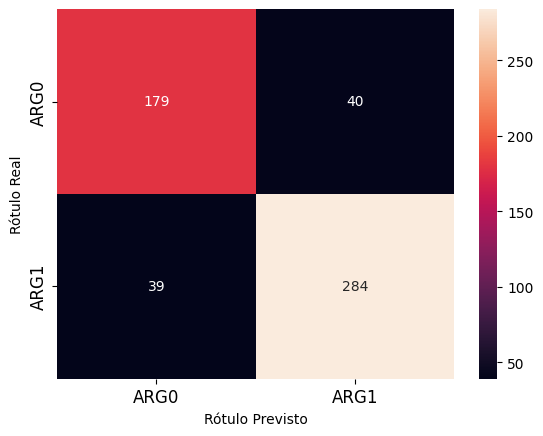

In [29]:

# Supondo que y_test e y_pred já estão definidos
cm = confusion_matrix(y_test, y_pred)

# Definir os rótulos desejados para os eixos
labels = [
    'ARG0', 
    'ARG1', 
    # 'ARG2', 
    # "ARG3", 
    # "ARG4"
    ]

# Plotar o heatmap
ax = sns.heatmap(cm, annot=True, fmt='g')

# Definir os rótulos dos eixos
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)

# Exibir o plot
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.show()

###############################################
# corpus name: lp
###############################################
          
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       119
           1       0.91      0.91      0.91       151

    accuracy                           0.90       270
   macro avg       0.90      0.90      0.90       270
weighted avg       0.90      0.90      0.90       270



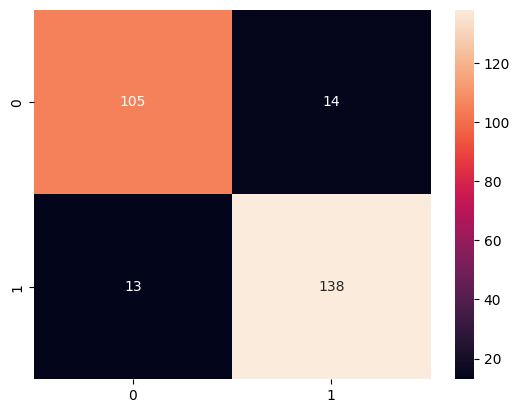

###############################################
# corpus name: news
###############################################
          
              precision    recall  f1-score   support

           0       0.68      0.67      0.67        60
           1       0.83      0.84      0.83       116

    accuracy                           0.78       176
   macro avg       0.75      0.75      0.75       176
weighted avg       0.78      0.78      0.78       176



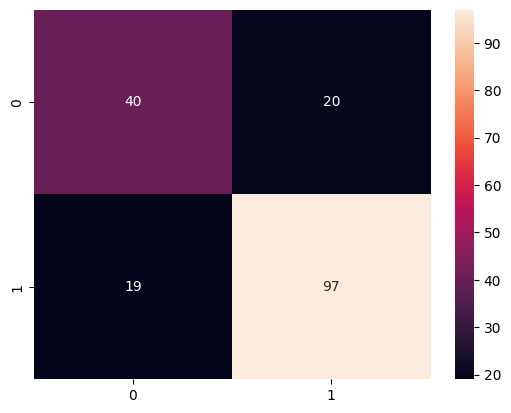

###############################################
# corpus name: opisums
###############################################
          
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        34
           1       0.86      0.86      0.86        43

    accuracy                           0.84        77
   macro avg       0.84      0.84      0.84        77
weighted avg       0.84      0.84      0.84        77



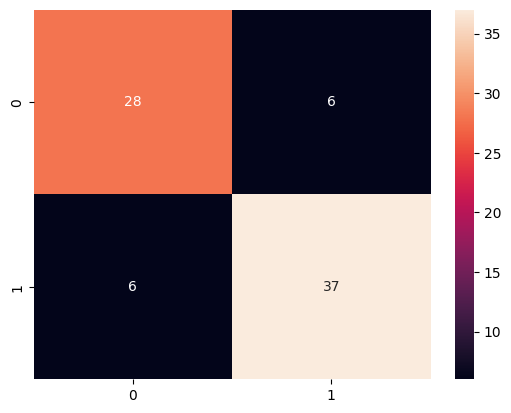

###############################################
# corpus name: sci
###############################################
          
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.92      0.96        13

    accuracy                           0.95        19
   macro avg       0.93      0.96      0.94        19
weighted avg       0.95      0.95      0.95        19



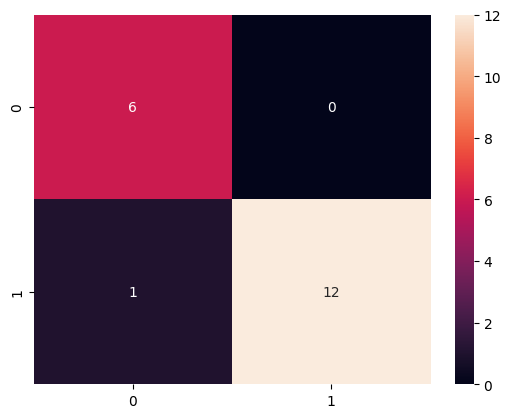

In [30]:
df_features_test = df_features.loc[y_test.index.tolist(), :]

df_anl = pd.DataFrame({
    "y_test": y_test.tolist(),
    "y_pred": y_pred.tolist(),
    "corpus_name": df_features.loc[y_test.index.tolist(), :]['corpus_name'].tolist(),  
})

for cp_nm in df_anl.corpus_name.unique():
    
    print(f"""###############################################
# corpus name: {cp_nm}
###############################################
          """)
    
    df_anl_cp = df_anl[df_anl.corpus_name == cp_nm]
    
    print(classification_report(df_anl_cp.y_test, df_anl_cp.y_pred))
    
    cm=confusion_matrix(df_anl_cp.y_test, df_anl_cp.y_pred)
    sns.heatmap(cm, annot=True, fmt='g') # font size
    plt.show()

### Featue importance

In [31]:
# # Acessar o objeto RFE na pipeline
# rfe = pipeline.named_steps['selecting']
# # Acessar o array que indica quais características foram selecionadas
# selected_features_mask = rfe.support_

selected_features_mask = model.named_steps['selecting'].get_support()

# Usar o array para filtrar os nomes das colunas do DataFrame original
selected_features = X_train.columns[selected_features_mask].tolist()

print("Características selecionadas pelo RFE:")
print(selected_features)


Características selecionadas pelo RFE:
['dep_acl', 'dep_aux', 'dep_ccomp', 'dep_fixed', 'dep_nmod', 'dep_nsubj', 'dep_nsubj:pass', 'dep_obj', 'dep_obl:agent', 'dep_parataxis', 'dep_xcomp', 'parent_text_Há', 'parent_text_Tem', 'parent_text_aconteceu', 'parent_text_atuou', 'parent_text_chorar', 'parent_text_conversar', 'parent_text_deixarei', 'parent_text_disse', 'parent_text_diz', 'parent_text_estava', 'parent_text_estavam', 'parent_text_esteve', 'parent_text_está', 'parent_text_estão', 'parent_text_evitar', 'parent_text_exclamou', 'parent_text_falava', 'parent_text_fazer', 'parent_text_fica', 'parent_text_ficou', 'parent_text_havia', 'parent_text_há', 'parent_text_informou', 'parent_text_joga', 'parent_text_moro', 'parent_text_morreu', 'parent_text_ocorreu', 'parent_text_parece', 'parent_text_perguntou', 'parent_text_pescar', 'parent_text_repetiu', 'parent_text_respondeu', 'parent_text_ser', 'parent_text_sorriu', 'parent_text_são', 'parent_text_vem', 'parent_text_é', 'parent_pos_AUX', 

In [32]:
# forma antiga de pegar a feature original
# # Função para remover a parte após o último underscore
# def remover_apos_ultimo_underscore(s):
#     return "_".join(s.split("_")[:-1])

# original_features = [remover_apos_ultimo_underscore(feat) for feat in selected_features]

In [33]:
def get_original_feature(feature):
    
    # resolve as features embeddings
    if "emb" in feature:
        
        return re.sub(r'_\d+_', '_', feature)
    
    
    original_features = ['corpus_name', 'dep', 'parent_text',
        'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
        'child_lemma', 'child_pos', 'child_tag', 'child_ner', 'parent', 'child']
    
    for o_feat in original_features:
        
        if o_feat in feature:
            
            return o_feat
        
    return None
    

original_features = [get_original_feature(feat) for feat in selected_features]

# Extrair o modelo XGBClassifier da pipeline
xgb_model = model.named_steps['estimator']

# Obter as importâncias das características
feature_importances = xgb_model.feature_importances_

# Criar um DataFrame para facilitar a manipulação e visualização
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    "original_feature": original_features,
    'importance': feature_importances
})

In [34]:
for idx, row in feature_importance_df.iterrows():
    
    print(row.feature,"|", row.original_feature)

dep_acl | dep
dep_aux | dep
dep_ccomp | dep
dep_fixed | dep
dep_nmod | dep
dep_nsubj | dep
dep_nsubj:pass | dep
dep_obj | dep
dep_obl:agent | dep
dep_parataxis | dep
dep_xcomp | dep
parent_text_Há | parent_text
parent_text_Tem | parent_text
parent_text_aconteceu | parent_text
parent_text_atuou | parent_text
parent_text_chorar | parent_text
parent_text_conversar | parent_text
parent_text_deixarei | parent_text
parent_text_disse | parent_text
parent_text_diz | parent_text
parent_text_estava | parent_text
parent_text_estavam | parent_text
parent_text_esteve | parent_text
parent_text_está | parent_text
parent_text_estão | parent_text
parent_text_evitar | parent_text
parent_text_exclamou | parent_text
parent_text_falava | parent_text
parent_text_fazer | parent_text
parent_text_fica | parent_text
parent_text_ficou | parent_text
parent_text_havia | parent_text
parent_text_há | parent_text
parent_text_informou | parent_text
parent_text_joga | parent_text
parent_text_moro | parent_text
parent_t

In [35]:
feature_importance_df.original_feature.value_counts()

original_feature
emb_lemma_child     300
emb_lemma_parent    300
child_text          158
parent_text          37
child_pos            13
child_tag            13
dep                  11
child_ner             5
parent_pos            2
parent_tag            2
Name: count, dtype: int64

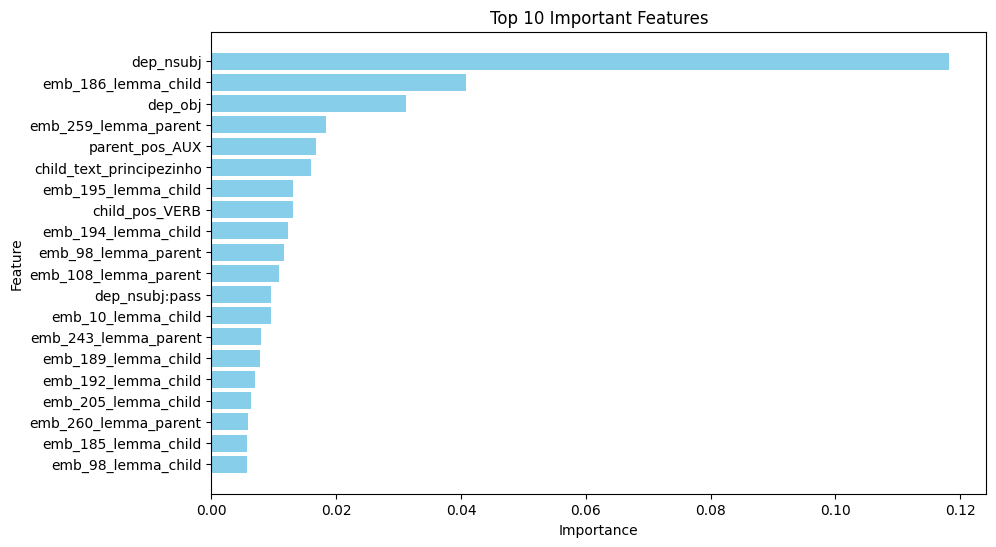

In [36]:


# Ordenar o DataFrame pelo valor de importância
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

# Plotar o gráfico de barras das principais características
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar a característica mais importante no topo
plt.show()


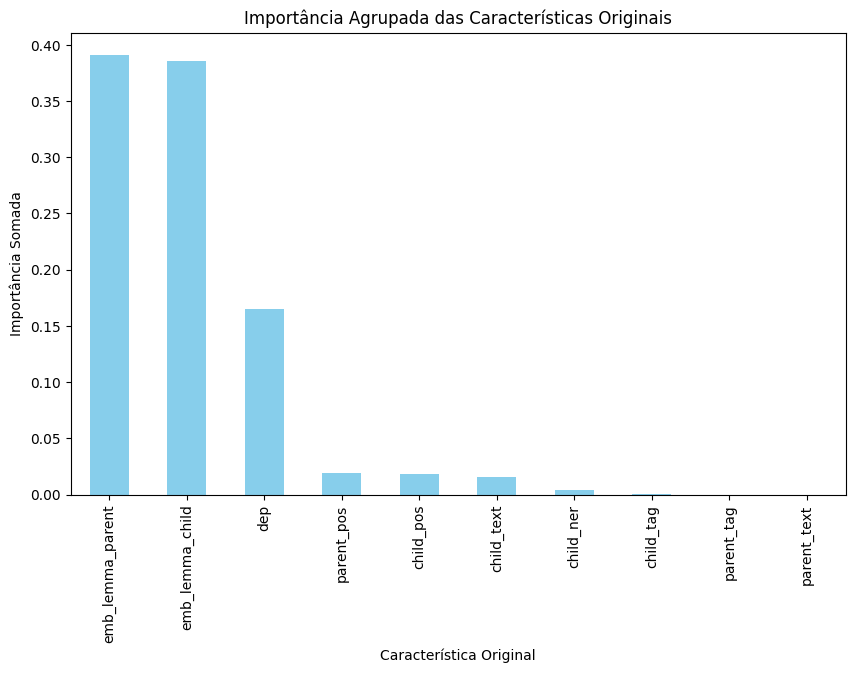

In [37]:
grouped_importances = feature_importance_df.groupby('original_feature')['importance'].sum().sort_values(ascending=False)
# Plotar o gráfico das características originais mais importantes
plt.figure(figsize=(10, 6))
grouped_importances.head(10).plot(kind='bar', color='skyblue')
plt.title('Importância Agrupada das Características Originais')
plt.xlabel('Característica Original')
plt.ylabel('Importância Somada')
plt.show()

### SHAP

In [ ]:
# 1. Carregar o modelo treinado do pipeline
xgb_model = model.named_steps['estimator']

# 2. Criar o objeto Explainer para o modelo XGB
explainer = shap.TreeExplainer(xgb_model)

In [ ]:
for step in [step[0] for step in model.steps if step[0] != "estimator"]:
    
    print(step)
    
    if step == "sampling":
        pass
    else:
        X_test_processed = model[step].transform(X_test)
        X_train_processed = model[step].transform(X_train)

In [ ]:
df_X_test_anl = pd.DataFrame(X_test_processed, columns = selected_features)
df_X_train_anl = pd.DataFrame(X_train_processed, columns = selected_features)

In [ ]:
# 3. Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(df_X_test_anl)

In [ ]:
explainer_2 = shap.Explainer(xgb_model, df_X_train_anl)
shap_values = explainer(df_X_train_anl)